In [323]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import math
import missingno
%matplotlib inline
sns.set_style("white")

sns.set_theme()
sns.set(rc={"figure.dpi":80})
sns.set(rc = {"figure.figsize":(10,5)})

In [347]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

#Create two seperate df
survive_df = train[train['Survived']==1]
dead_df = train[train['Survived']==0]

train.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [536]:
train.Name.values

array(['Braund, Mr. Owen Harris',
       'Cumings, Mrs. John Bradley (Florence Briggs Thayer)',
       'Heikkinen, Miss. Laina',
       'Futrelle, Mrs. Jacques Heath (Lily May Peel)',
       'Allen, Mr. William Henry', 'Moran, Mr. James',
       'McCarthy, Mr. Timothy J', 'Palsson, Master. Gosta Leonard',
       'Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)',
       'Nasser, Mrs. Nicholas (Adele Achem)',
       'Sandstrom, Miss. Marguerite Rut', 'Bonnell, Miss. Elizabeth',
       'Saundercock, Mr. William Henry', 'Andersson, Mr. Anders Johan',
       'Vestrom, Miss. Hulda Amanda Adolfina',
       'Hewlett, Mrs. (Mary D Kingcome) ', 'Rice, Master. Eugene',
       'Williams, Mr. Charles Eugene',
       'Vander Planke, Mrs. Julius (Emelia Maria Vandemoortele)',
       'Masselmani, Mrs. Fatima', 'Fynney, Mr. Joseph J',
       'Beesley, Mr. Lawrence', 'McGowan, Miss. Anna "Annie"',
       'Sloper, Mr. William Thompson', 'Palsson, Miss. Torborg Danira',
       'Asplund, Mrs. Carl Oscar 

In [477]:
print(train.shape)

(891, 12)


In [478]:
print(test.shape)

(418, 11)


<AxesSubplot:>

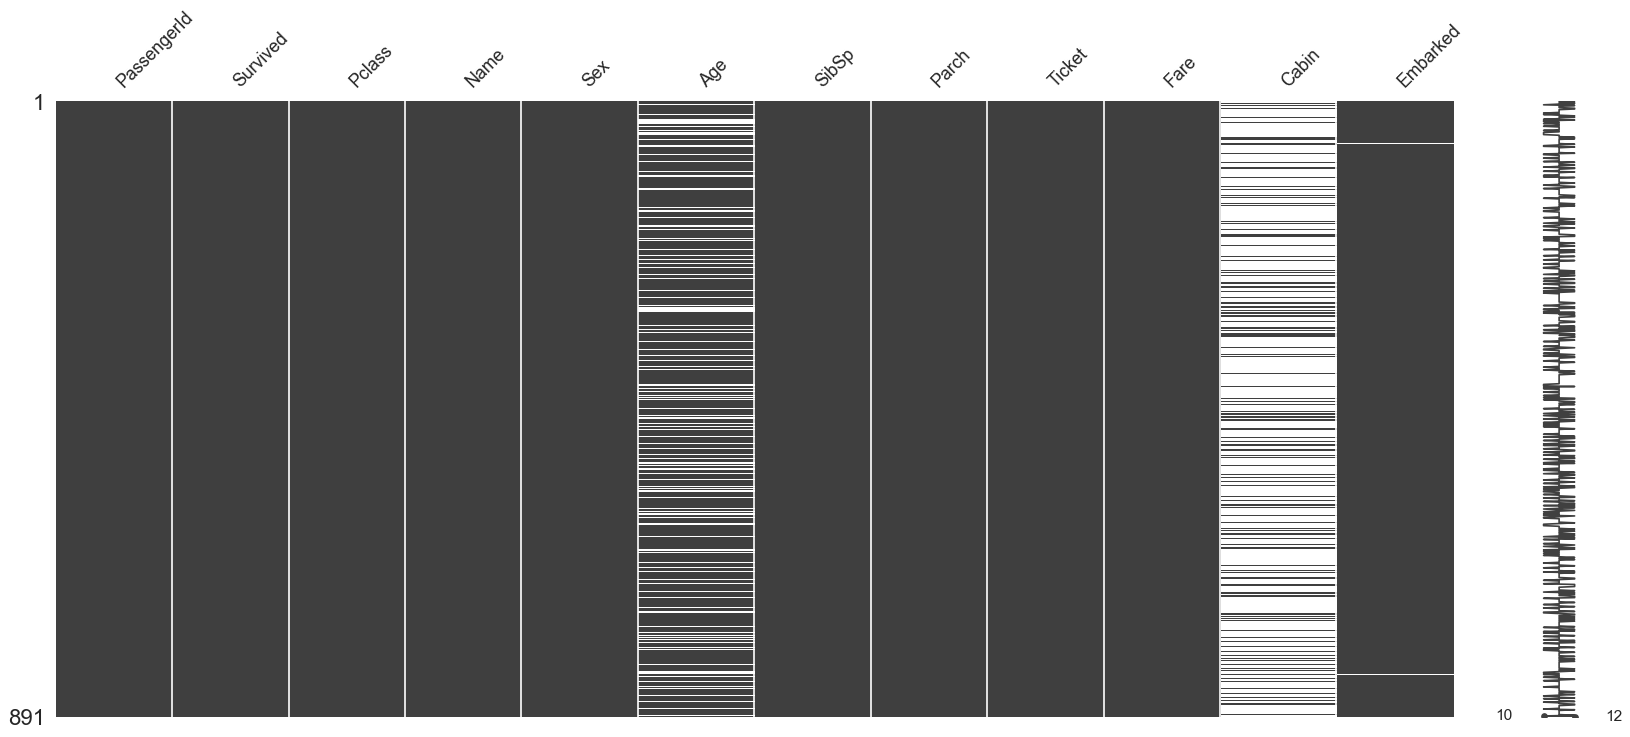

In [325]:
missingno.matrix(train)

In [40]:
print(train.shape)
print(f"There are {train[train['Sex']=='male'].Sex.count()} male.")
print(f"There are {train[train['Sex']=='female'].Sex.count()} female.")
print(f'Age range from {train.Age.min()} to {train.Age.max()} years old')
print(f'{survive_df.PassengerId.count()} people survived, {dead_df.PassengerId.count()} people died.')

(891, 12)
There are 577 male.
There are 314 female.
Age range from 0.42 to 80.0 years old
342 people survived, 549 people died.


In [494]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

class FeatureDropper(BaseEstimator,TransformerMixin):
    def fit(self,X,y=None):
        return self
    def transform(self,X):
        return X.drop(['Name','PassengerId', 'Ticket','Cabin'],axis=1)

class Imputer(BaseEstimator,TransformerMixin):
    def fit(self,X,y=None):
        return self
    def transform(self,X):
        #Impute Age
        imputer = SimpleImputer(strategy='mean')
        X['Age'] = imputer.fit_transform(X['Age'].values.reshape(-1,1))[:,0]
        
        #Impute Embarked
        imputer = SimpleImputer(strategy='most_frequent')
        X['Embarked'] = imputer.fit_transform(X['Embarked'].values.reshape(-1,1))[:,0]
        
        #Impute Fare
        imputer = SimpleImputer(strategy='mean')
        X['Fare'] = imputer.fit_transform(X['Fare'].values.reshape(-1,1))[:,0]
        return X
    
class UnitAdjust(BaseEstimator,TransformerMixin):
    def fit(self,X,y=None):
        return self
    def transform(self,X):
        X['Age'] = X['Age'].apply(lambda y: math.floor(y))
        X['Fare'] = X['Fare'].apply(lambda f: round(f,1))
        return X
    

class Companion(BaseEstimator,TransformerMixin):
    def fit(self,X,y=None):
        return self
    def transform(self,X):
        X['companion'] = X['SibSp'] + X['Parch']
        return X.drop(['SibSp','Parch'],axis=1)
    
class TitleFeature(BaseEstimator,TransformerMixin):
    def fit(self,X,y=None):
        return self
    def transform(self,X):
        lr = ['Mr','Mrs','Miss','Ms','Mlle']
        def rank_title(x):
            if x in lr:
                return 'LR'
            else:
                return 'HR'
        X['title'] = X['Name'].str.split(',',expand=True)[1].str.split('.',expand=True)[0].str.strip()
        X['title'] = X['title'].apply(rank_title)
        return X
      
class FeatureBinarize(BaseEstimator,TransformerMixin):
    def fit(self,X,y=None):
        return self
    def transform(self,X):
        # Gender binarize
        gender_dct = {'male':0, 'female':1}
        X['Sex'] = [gender_dct[g] for g in X['Sex']]
        
        #Title binarize - Classify low rank and high rank 
        title_dct = {'LR':0, 'HR':1}
        X['title'] = [title_dct[t] for t in X['title']]
        
        #Companion binarize
        def is_alone(x):
            if x > 0:
                return 1
            else:
                return 0
        X['companion'] = X['companion'].apply(is_alone)
        
        return X

class FeatureEncoder(BaseEstimator,TransformerMixin):
    def fit(self,X,y=None):
        return self
    def transform(self,X):
        encoder = OneHotEncoder()
        matrix = encoder.fit_transform(X["Embarked"].values.reshape(-1,1)).toarray()
        column_name = ['C','Q','S']
        for i in range(len(matrix.T)):
            X[column_name[i]] = matrix.T[i]
        return X.drop(['Embarked'],axis=1)
    
class TableauSTR(BaseEstimator,TransformerMixin):
    def fit(self,X,y=None):
        return self
    def transform(self,X):
        #Embarked dict
        embarked_dct = {'S': 'Southampton', 'C': 'Cherbourg', 'Q': 'Queenstown'}
        X['Embarked'] = [embarked_dct[e] for e in X['Embarked']]
        #pclass dct
        pclass_dct = {1: '1st', 2: '2nd', 3:'3rd'}
        X['Pclass'] = [pclass_dct[c] for c in X['Pclass']]
        #status_dct
#         status_dct = {0: 'Dead', 1:'Survived'}
#         X['Survived'] = [status_dct[s] for s in X['Survived']]
        return X



In [495]:
pipe = Pipeline([
    ('imputer',Imputer()),
    ('title',TitleFeature()),
    ('binarize',FeatureBinarize()),
    ('encoder',FeatureEncoder()),
    ('dropper',FeatureDropper()),
    ('companion',Companion()),
    ('unit',UnitAdjust()),
])

train_ab = pipe.fit_transform(train.copy())

In [496]:
pipe_tableau = Pipeline([
    ('imputer',Imputer()),
    ('title',TitleFeature()),
    ('dropper',FeatureDropper()),
    ('converter',TableauSTR()),
    ('companion',Companion()),
    ('unit',UnitAdjust()),
])

df_tableau = pipe_tableau.fit_transform(train.copy())
df_tableau

,Survived,Pclass,Sex,Age,Fare,Embarked,title,companion
0,0,3rd,male,22,7.2,Southampton,LR,1
1,1,1st,female,38,71.3,Cherbourg,LR,1
2,1,3rd,female,26,7.9,Southampton,LR,0
3,1,1st,female,35,53.1,Southampton,LR,1
4,0,3rd,male,35,8.1,Southampton,LR,0
...,...,...,...,...,...,...,...,...
886,0,2nd,male,27,13.0,Southampton,HR,0
887,1,1st,female,19,30.0,Southampton,LR,0
888,0,3rd,female,29,23.4,Southampton,LR,1
889,1,1st,male,26,30.0,Cherbourg,LR,0


<AxesSubplot:>

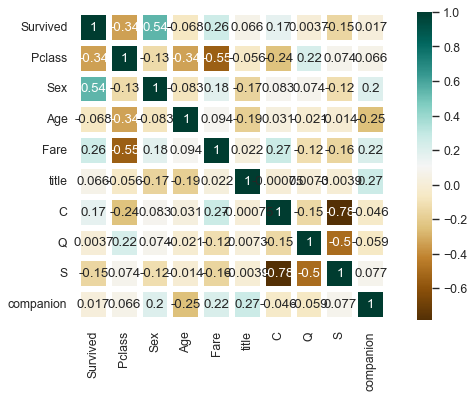

In [422]:
sns.heatmap(train_ab.corr(), annot=True, cmap="BrBG", square=True, linewidths=5)

In [497]:
pipe = Pipeline([
    ('imputer',Imputer()),
    ('title',TitleFeature()),
    ('binarize',FeatureBinarize()),
    ('encoder',FeatureEncoder()),
    ('dropper',FeatureDropper()),
    ('companion',Companion()),
    ('unit',UnitAdjust()),
])

test_ab = pipe.fit_transform(test.copy())
test_ab.isna().sum()

Pclass       0
Sex          0
Age          0
Fare         0
title        0
C            0
Q            0
S            0
companion    0
dtype: int64

In [498]:
from sklearn.preprocessing import StandardScaler

X = train_ab.drop(['Survived'],axis=1)
y = train_ab['Survived']

scaler = StandardScaler()
X_train = scaler.fit_transform(X)
y_train = y.to_numpy()

In [499]:
scaler = StandardScaler()
X_test = scaler.fit_transform(test_ab)

# Modelling

In [500]:
from sklearn.linear_model import LogisticRegression, Perceptron, SGDClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV


### Logistic regression

In [501]:
logreg = LogisticRegression()
logreg.fit(X_train,y_train)
Y_pred = logreg.predict(X_test)
acc_log = round(logreg.score(X_train,y_train)*100,2)
acc_log

80.25

### Support Vectore Machines

In [502]:
svc = SVC()
svc.fit(X_train,y_train)
Y_pred = svc.predict(X_test)
acc_svc = round(svc.score(X_train,y_train)*100,2)
acc_svc

83.39

### Linear SVC

In [503]:
linear_svc = LinearSVC()
linear_svc.fit(X_train,y_train)
Y_pred = linear_svc.predict(X_test)
acc_linear_svc = round(linear_svc.score(X_train,y_train)*100,2)
acc_linear_svc

/Users/jadonng/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


80.58

### Decision Tree

In [504]:
decision_tree = DecisionTreeClassifier()
decision_tree.fit(X_train,y_train)
Y_pred = decision_tree.predict(X_test)
acc_decision_tree = round(decision_tree.score(X_train,y_train)*100,2)
acc_decision_tree

97.42

### Random Forest

In [505]:
random_forest = RandomForestClassifier(n_estimators=100)
random_forest.fit(X_train,y_train)
Y_pred = random_forest.predict(X_test)
acc_random_forest = round(random_forest.score(X_train,y_train)*100,2)
acc_random_forest

97.42

### K-nearest neighbors

In [506]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train,y_train)
Y_pred = knn.predict(X_test)
acc_knn = round(knn.score(X_train,y_train)*100,2)
acc_knn

/Users/jadonng/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/jadonng/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no long

86.31

### Gaussian naive bayes

In [507]:
gaussian = GaussianNB()
gaussian.fit(X_train,y_train)
Y_pred = gaussian.predict(X_test)
acc_gaussian = round(gaussian.score(X_train,y_train)*100,2)
acc_gaussian

74.86

### Perceptron

In [508]:
perceptron = Perceptron()
perceptron.fit(X_train,y_train)
Y_pred = perceptron.predict(X_test)
acc_perceptron = round(perceptron.score(X_train,y_train)*100,2)
acc_perceptron

73.4

### Stochastic gradient descent

In [509]:
SGD = SGDClassifier()
SGD.fit(X_train,y_train)
Y_pred = SGD.predict(X_test)
acc_SGD = round(SGD.score(X_train,y_train)*100,2)
acc_SGD

78.23

## K-fold cross validation

In [511]:
classifier = []
classifier.append(LogisticRegression())
classifier.append(SVC())
classifier.append(LinearSVC())
classifier.append(DecisionTreeClassifier())
classifier.append(RandomForestClassifier(n_estimators=100))
classifier.append(KNeighborsClassifier(n_neighbors=5))
classifier.append(GaussianNB())
classifier.append(Perceptron())
classifier.append(SGDClassifier())

In [510]:
cv_results = []
for i in classifier:
    cv_results.append(cross_val_score(i,X_train,y_train,scoring='accuracy',cv=10))

/Users/jadonng/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/jadonng/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/jadonng/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/jadonng/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/jadonng/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/jadonng/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_

In [512]:
cv_mean = []
cv_std = []
for result in cv_results:
    cv_mean.append(result.mean())
    cv_std.append(result.std())

In [513]:
cv_res = pd.DataFrame({'Cross Validation Mean': cv_mean,
                       'Cross Validation Std': cv_std,
                      'Model' : ['Logistic Regression', 'Support Vector Machines',
                                 'Linear SVC','Decision Tree','Random Forest','KNN',
                                'GaussianNB','Perceptron','Stochastic gradient descent']})
cv_res = cv_res.sort_values(by='Cross Validation Mean',ascending=False,ignore_index=True)
cv_res

,Cross Validation Mean,Cross Validation Std,Model
0,0.827191,0.033595,Support Vector Machines
1,0.819351,0.044833,Random Forest
2,0.815993,0.032623,KNN
3,0.800237,0.029112,Logistic Regression
4,0.798040,0.047869,Decision Tree
5,0.796829,0.030909,Linear SVC
6,0.740799,0.058808,Stochastic gradient descent
7,0.735268,0.052180,GaussianNB
8,0.697004,0.085578,Perceptron


### Hypertuning SVC

In [514]:
param_grid = {'C': [0.1, 1, 10, 100, 1000],  
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001], 
              'kernel': ['rbf']}  
  
grid = GridSearchCV(SVC(), param_grid, refit = True, verbose = 3) 

grid.fit(X_train, y_train) 

Fitting 5 folds for each of 25 candidates, totalling 125 fits
[CV 1/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.771 total time=   0.1s
[CV 2/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.764 total time=   0.0s
[CV 3/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.747 total time=   0.0s
[CV 4/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.758 total time=   0.0s
[CV 5/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.719 total time=   0.0s
[CV 1/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.782 total time=   0.0s
[CV 2/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.815 total time=   0.0s
[CV 3/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.787 total time=   0.0s
[CV 4/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.753 total time=   0.0s
[CV 5/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.792 total time=   0.0s
[CV 1/5] END .....C=0.1, gamma=0.01, kernel=rbf;, score=0.676 total time=   0.0s
[CV 2/5] END .....C=0.1, gamma=0.01, kernel=rbf

[CV 2/5] END .......C=1000, gamma=1, kernel=rbf;, score=0.742 total time=   0.1s
[CV 3/5] END .......C=1000, gamma=1, kernel=rbf;, score=0.781 total time=   0.1s
[CV 4/5] END .......C=1000, gamma=1, kernel=rbf;, score=0.758 total time=   0.1s
[CV 5/5] END .......C=1000, gamma=1, kernel=rbf;, score=0.764 total time=   0.1s
[CV 1/5] END .....C=1000, gamma=0.1, kernel=rbf;, score=0.777 total time=   0.1s
[CV 2/5] END .....C=1000, gamma=0.1, kernel=rbf;, score=0.758 total time=   0.1s
[CV 3/5] END .....C=1000, gamma=0.1, kernel=rbf;, score=0.803 total time=   0.2s
[CV 4/5] END .....C=1000, gamma=0.1, kernel=rbf;, score=0.787 total time=   0.1s
[CV 5/5] END .....C=1000, gamma=0.1, kernel=rbf;, score=0.809 total time=   0.1s
[CV 1/5] END ....C=1000, gamma=0.01, kernel=rbf;, score=0.816 total time=   0.1s
[CV 2/5] END ....C=1000, gamma=0.01, kernel=rbf;, score=0.831 total time=   0.1s
[CV 3/5] END ....C=1000, gamma=0.01, kernel=rbf;, score=0.809 total time=   0.1s
[CV 4/5] END ....C=1000, gam

GridSearchCV(estimator=SVC(),
             param_grid={'C': [0.1, 1, 10, 100, 1000],
                         'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                         'kernel': ['rbf']},
             verbose=3)

In [516]:
print("Best parameters: ", grid.best_params_) 
print("Best estimator: ", grid.best_estimator_)

Best parameters:  {'C': 1, 'gamma': 0.1, 'kernel': 'rbf'}
Best estimator:  SVC(C=1, gamma=0.1)


In [517]:
svc = SVC(C = 1, gamma = 0.1, kernel = 'rbf')
svc.fit(X_train, y_train)
Y_pred = svc.predict(X_test)
acc_svc = round(svc.score(X_train, y_train) * 100, 2)
acc_svc

83.28

In [518]:
cross_val_score(svc, X_train, y_train, scoring = 'accuracy', cv = 10).mean()

0.8271910112359551

In [541]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis 
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score
model = LinearDiscriminantAnalysis()
model.fit(X_train, y_train)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
scores = cross_val_score(model, X_train, y_train, scoring='accuracy', cv=cv, n_jobs=-1)
scores.mean()

0.7945984186433622

In [519]:
Y_pred

array([0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0,
       1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1,
       1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0,
       1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0,
       0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,

In [520]:
len(Y_pred)

418

In [526]:
test.PassengerId.values

array([ 892,  893,  894,  895,  896,  897,  898,  899,  900,  901,  902,
        903,  904,  905,  906,  907,  908,  909,  910,  911,  912,  913,
        914,  915,  916,  917,  918,  919,  920,  921,  922,  923,  924,
        925,  926,  927,  928,  929,  930,  931,  932,  933,  934,  935,
        936,  937,  938,  939,  940,  941,  942,  943,  944,  945,  946,
        947,  948,  949,  950,  951,  952,  953,  954,  955,  956,  957,
        958,  959,  960,  961,  962,  963,  964,  965,  966,  967,  968,
        969,  970,  971,  972,  973,  974,  975,  976,  977,  978,  979,
        980,  981,  982,  983,  984,  985,  986,  987,  988,  989,  990,
        991,  992,  993,  994,  995,  996,  997,  998,  999, 1000, 1001,
       1002, 1003, 1004, 1005, 1006, 1007, 1008, 1009, 1010, 1011, 1012,
       1013, 1014, 1015, 1016, 1017, 1018, 1019, 1020, 1021, 1022, 1023,
       1024, 1025, 1026, 1027, 1028, 1029, 1030, 1031, 1032, 1033, 1034,
       1035, 1036, 1037, 1038, 1039, 1040, 1041, 10

In [535]:
submit = pd.DataFrame({'PassengerId':test.PassengerId.values,'Survived': Y_pred})
submit

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0


In [529]:
# submit.to_csv('Titanic_submission1.csv',index=False)

## Random Forest

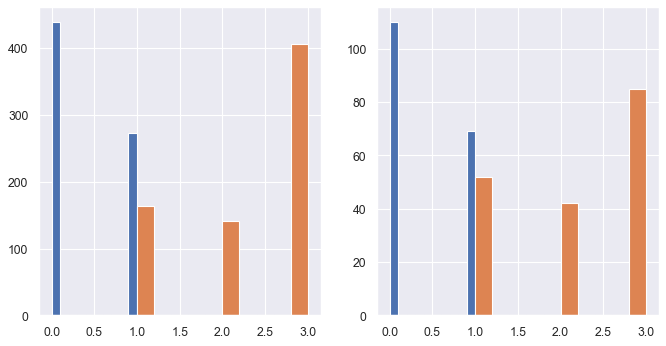

In [521]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1,test_size=0.2) #test_size is 20% of data
for train_indices, test_indices in split.split(train_ab,train_ab[['Survived','Sex']]): 
    # we indicating that survived, pclass and sex should be equally split
    strat_train_set = train_ab.loc[train_indices]
    strat_test_set = train_ab.loc[test_indices]
    

# the following code should help us verify that the sets are equally split among survived, pclass and sex
plt.subplot(1,2,1)
strat_train_set['Survived'].hist()
strat_train_set['Pclass'].hist()

plt.subplot(1,2,2)
strat_test_set['Survived'].hist()
strat_test_set['Pclass'].hist()

plt.show()

In [375]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

clf = RandomForestClassifier()
param_grid = [
    {'n_estimators':[10,100,200,500], 'max_depth': [None,5,10], 'min_samples_split': [2,3,4]}
]

grid_search = GridSearchCV(clf,param_grid,cv=3,scoring='accuracy',return_train_score=True)
grid_search.fit(X_data,y_data)

GridSearchCV(cv=3, estimator=RandomForestClassifier(),
             param_grid=[{'max_depth': [None, 5, 10],
                          'min_samples_split': [2, 3, 4],
                          'n_estimators': [10, 100, 200, 500]}],
             return_train_score=True, scoring='accuracy')

In [376]:
final_clf = grid_search.best_estimator_
final_clf

RandomForestClassifier(max_depth=5, n_estimators=500)

In [377]:
X_test = strat_test_set.drop(['Survived'],axis=1)
y_test = strat_test_set['Survived']

scaler = StandardScaler()
X_test_data = scaler.fit_transform(X_test)
y_test_data = y_test.to_numpy()

In [378]:
final_clf.score(X_test_data,y_test_data)

0.8156424581005587